# Двойное и тройное экспоненциальное сглаживание

### Пример [из документации](https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html#The-Internals)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

%matplotlib inline

data = [
    17.5534,
    21.86,
    23.8866,
    26.9293,
    26.8885,
    28.8314,
    30.0751,
    30.9535,
    30.1857,
    31.5797,
    32.5776,
    33.4774,
    39.0216,
    41.3864,
    41.5966,
]
index = pd.date_range(start="1990", end="2005", freq="A")
air = pd.Series(data, index)

data = [
    263.9177,
    268.3072,
    260.6626,
    266.6394,
    277.5158,
    283.834,
    290.309,
    292.4742,
    300.8307,
    309.2867,
    318.3311,
    329.3724,
    338.884,
    339.2441,
    328.6006,
    314.2554,
    314.4597,
    321.4138,
    329.7893,
    346.3852,
    352.2979,
    348.3705,
    417.5629,
    417.1236,
    417.7495,
    412.2339,
    411.9468,
    394.6971,
    401.4993,
    408.2705,
    414.2428,
]
index = pd.date_range(start="1970", end="2001", freq="A")
livestock2 = pd.Series(data, index)

data = [407.9979, 403.4608, 413.8249, 428.105, 445.3387, 452.9942, 455.7402]
index = pd.date_range(start="2001", end="2008", freq="A")
livestock3 = pd.Series(data, index)

data = [
    41.7275,
    24.0418,
    32.3281,
    37.3287,
    46.2132,
    29.3463,
    36.4829,
    42.9777,
    48.9015,
    31.1802,
    37.7179,
    40.4202,
    51.2069,
    31.8872,
    40.9783,
    43.7725,
    55.5586,
    33.8509,
    42.0764,
    45.6423,
    59.7668,
    35.1919,
    44.3197,
    47.9137,
]
index = pd.date_range(start="2005", end="2010-Q4", freq="QS-OCT")
aust = pd.Series(data, index)

### Двойное экспоненциальное сглаживание (модель Хольта с трендом)

Модель (с аддитивным трендом)
$$\tilde y_{t+d} = \tilde l_t + \tilde b_t\cdot d,$$
где
$$\tilde l_t = \alpha y_t + (1-\alpha)(\tilde l_{t-1}+\tilde b_{t-1}),$$
$$\tilde b_t = \beta(\tilde l_t - \tilde l_{t-1}) + (1-\beta)\tilde b_{t-1}.$$

Также в библиотеке реализована модель с экспоненциальным трендом.

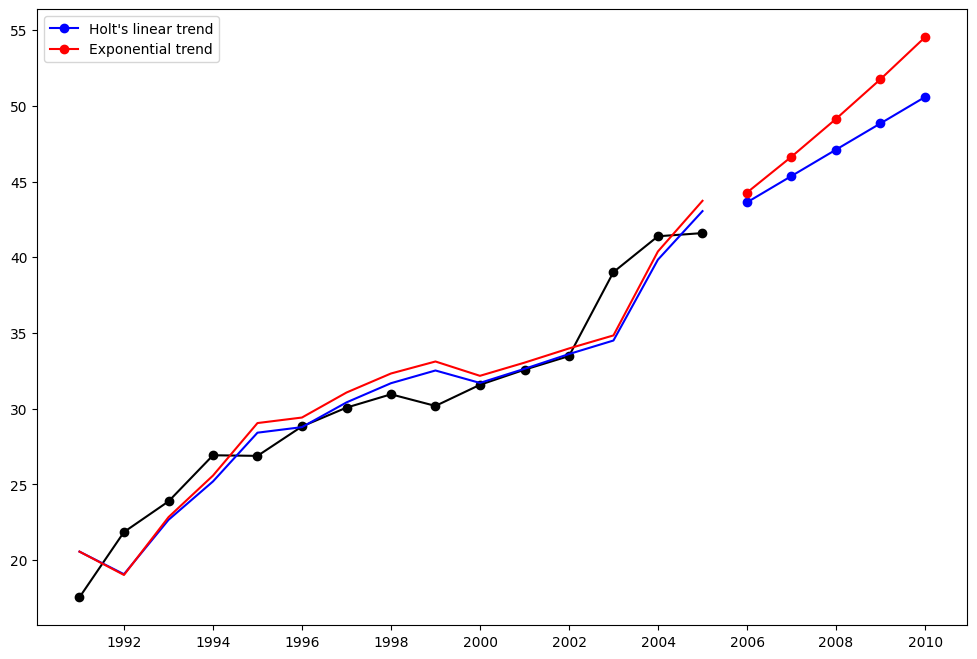

In [3]:
fit1 = Holt(air, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
fcast1 = fit1.forecast(5).rename("Holt's linear trend")

fit2 = Holt(air, exponential=True, initialization_method="estimated").fit(
    smoothing_level=0.8, smoothing_trend=0.2, optimized=False
)
fcast2 = fit2.forecast(5).rename("Exponential trend")

plt.figure(figsize=(12, 8))
plt.plot(air, marker="o", color="black")
plt.plot(fit1.fittedvalues, color="blue")
(line1,) = plt.plot(fcast1, marker="o", color="blue")
plt.plot(fit2.fittedvalues, color="red")
(line2,) = plt.plot(fcast2, marker="o", color="red")
plt.legend([line1, line2], [fcast1.name, fcast2.name])

### Тройное экспоненциальное сглаживание (модель Хольта-Винтерса с трендом и сезонностью)

Рассмотрим две модели:

1) Модель с аддитивными трендом и сезонностью

2) Модель с аддитивным трендом и мультипликативной сезонностью

Модель (с аддитивным трендом и сезонностью периода $p$) имеет вид
$$\tilde y_{t+d} = \tilde l_t + \tilde b_t\cdot d + \tilde s_{t+d mod(p)-p},$$
где
$$\tilde l_t = \alpha(y_t-\tilde s_{t-p}) + (1-\alpha)(\tilde l_{t-1}+\tilde b_{t-1}),$$
$$\tilde b_t = \beta(\tilde l_t - \tilde l_{t-1}) + (1-\beta)\tilde b_{t-1},$$
$$\tilde s_t = \gamma(y_t-\tilde l_t) + (1-\gamma)\tilde s_{t-p}$$

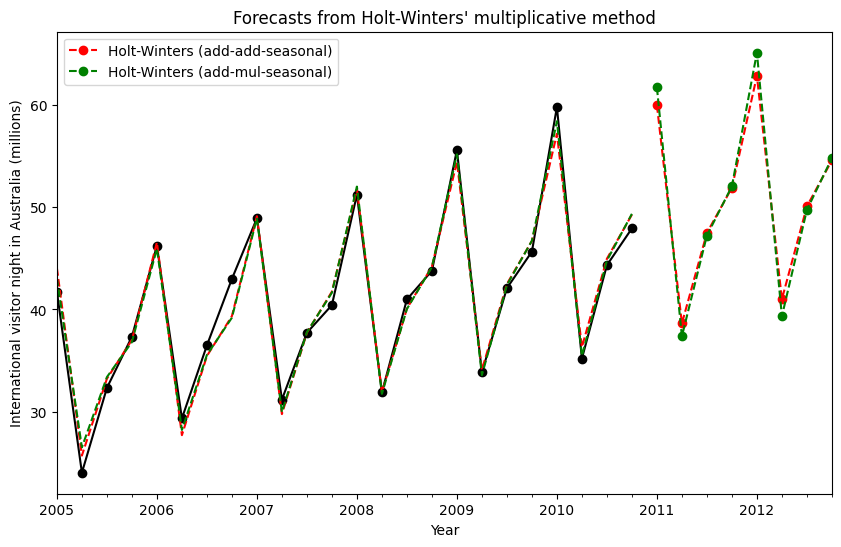

Figure 7.6: Forecasting international visitor nights in Australia using Holt-Winters method with both additive and multiplicative seasonality.


In [4]:
fit1 = ExponentialSmoothing(
    aust,
    seasonal_periods=4,
    trend="add",
    seasonal="add",
    use_boxcox=True,
    initialization_method="estimated",
).fit()

fit2 = ExponentialSmoothing(
    aust,
    seasonal_periods=4,
    trend="add",
    seasonal="mul",
    use_boxcox=True,
    initialization_method="estimated",
).fit()

results = pd.DataFrame(
    index=[r"$\alpha$", r"$\beta$", r"$\phi$", r"$\gamma$", r"$l_0$", "$b_0$", "SSE"]
)

ax = aust.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters' multiplicative method",
)

ax.set_ylabel("International visitor night in Australia (millions)")
ax.set_xlabel("Year")

fit1.fittedvalues.plot(ax=ax, style="--", color="red")
fit2.fittedvalues.plot(ax=ax, style="--", color="green")

fit1.forecast(8).rename("Holt-Winters (add-add-seasonal)").plot(
    ax=ax, style="--", marker="o", color="red", legend=True
)
fit2.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(
    ax=ax, style="--", marker="o", color="green", legend=True
)

plt.show()
print(
    "Figure 7.6: Forecasting international visitor nights in Australia using Holt-Winters method with both additive and multiplicative seasonality."
)